In [1]:
    import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
device

'cuda'

In [2]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [3]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [4]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

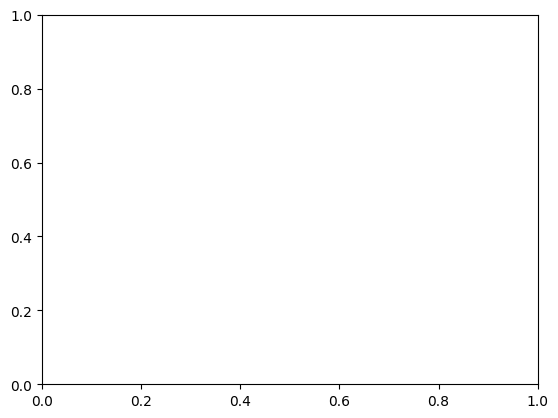

In [13]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [ ]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X = X.to(device)
y = y.to(device)

# View the first five samples
X[:5], y[:5]

In [ ]:
test = X.numpy()
test
# cuda doesnt work on laptop ig nvm it DOES.

In [14]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [15]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)

    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) #computation goes through layer 1 and the output goes through layer 2

In [16]:
model = CircleModel()
model.to(device)

CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
# Make predictions with the model
untrained_preds = model(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.1664],
        [-0.1068],
        [-0.1620],
        [-0.1683],
        [ 0.0930],
        [ 0.1274],
        [ 0.0932],
        [ 0.1487],
        [-0.1728],
        [-0.1000]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')


In [18]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.2)

In [19]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [20]:
correct = torch.eq(untrained_preds, y_test.to(device)) # stuff to assist my own understanding
correct.sum()

tensor(0, device='cuda:0')

In [38]:
#training loop

epochs = 200    # go here: https://www.learnpytorch.io/02_pytorch_classification/#3-train-model

for epoch in range(epochs):
    model.train()
    y_logits = model(X_train) # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_predictions = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    loss = loss_fn(y_logits, y_train.unsqueeze(dim=1)) # calc loss
    acc = accuracy_fn(y_true=y_train, y_pred=y_predictions)
    optimizer.zero_grad() # zero gradients
    loss.backward() # backpropagation
    optimizer.step()

    if epoch % 10 == 0:
        model.eval()
        with torch.inference_mode():
            test_predictions = torch.round(torch.sigmoid(model(X_test))).squeeze()
            test_loss = loss_fn(test_predictions, y_test)
            test_acc = accuracy_fn(test_predictions, y_test)
        print(test_predictions.shape, y_test.shape)
        print(torch.eq(y_test, test_predictions).sum().item())
        print(f"Epoch {epoch} | Accuracy: {acc:.2f}% | Loss: {loss:.7f} | Test accuracy: {acc}")

torch.Size([200]) torch.Size([200])
92
Epoch 0 | Accuracy: 40000.00% | Loss: 0.6929799 | Test accuracy: 40000.0
torch.Size([200]) torch.Size([200])
92
Epoch 10 | Accuracy: 40000.00% | Loss: 0.6929799 | Test accuracy: 40000.0
torch.Size([200]) torch.Size([200])
92
Epoch 20 | Accuracy: 40000.00% | Loss: 0.6929799 | Test accuracy: 40000.0
torch.Size([200]) torch.Size([200])
92
Epoch 30 | Accuracy: 40000.00% | Loss: 0.6929799 | Test accuracy: 40000.0
torch.Size([200]) torch.Size([200])
92
Epoch 40 | Accuracy: 40000.00% | Loss: 0.6929799 | Test accuracy: 40000.0
torch.Size([200]) torch.Size([200])
92
Epoch 50 | Accuracy: 40000.00% | Loss: 0.6929799 | Test accuracy: 40000.0
torch.Size([200]) torch.Size([200])
92
Epoch 60 | Accuracy: 40000.00% | Loss: 0.6929799 | Test accuracy: 40000.0
torch.Size([200]) torch.Size([200])
92
Epoch 70 | Accuracy: 40000.00% | Loss: 0.6929799 | Test accuracy: 40000.0
torch.Size([200]) torch.Size([200])
92
Epoch 80 | Accuracy: 40000.00% | Loss: 0.6929799 | Test ac